In [1]:
%pylab inline
import wradlib
import cv2
import numpy as np
import os
from matplotlib import animation
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from scipy.ndimage import zoom
import datetime
import warnings
warnings.simplefilter('once', DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


## Read sample data

Data is from the German Weather Service: the so called RY product represents rainfall intensity composite for the whole of Germany in 5 minute intervals. 

Spatial resolution: `1 x 1 km`; spatial extent: `900 x 900 km`.

**Information required from user**

- specify the directory `datadir` where you store the RY data (unpack the ry archives there).
- select a specific interval by commenting/uncommenting the `dtimes` lines.
- decide whether you need to reduce the resolution (downsize the image by a `downsizeby`) in order to avoid memory problems (this becomes relevant once you solve the 2D-adveciton equation...)

In [2]:
# Set data directory
datadir = "data/ry"

# Original grid dimensions
nx = 900
ny = 900

# pixel size (in meters)
dx = 1000.
dy = 1000.

# Downsize by factor "downsizeby"
#    downsizeby = 1 will leave the dimensions unchanged,
#    but for a 900x900 km grid, downsizing might be 
#    required in order to avoid MemoryError
downsizeby = 1

# interval between observations (in seconds)
interval = 300

# Set time window
##dtimes = wradlib.util.from_to("2008-06-02 17:00:00", "2008-06-02 19:00:00", interval)
##dtimes = wradlib.util.from_to("2015-04-26 17:00:00", "2015-04-26 19:00:00", interval)
##dtimes = wradlib.util.from_to("2015-03-29 17:00:00", "2015-03-29 19:00:00", interval)
dtimes = wradlib.util.from_to("2016-05-29 16:00:00", "2016-05-29 19:00:00", interval)

In [3]:
# Compute grid dimensions and grid coordinates after resampling
dx2, dy2 = dx*downsizeby, dy*downsizeby
nx2, ny2 = nx/downsizeby, ny/downsizeby

X2, Y2 = np.meshgrid( np.arange(0,nx2*dx2, dx2), np.arange(0,ny2*dy2, dy2) )

# Define container
frames = np.zeros( (len(dtimes), nx2, ny2 ) )

# Read the data, convert back to dBZ, and downsize
#   (maybe also try with keeping mm/h instead of converting to dBZ?)
for i, dtime in enumerate(dtimes):
    fname = dtime.strftime( os.path.join(datadir, "raa01-ry_10000-%y%m%d%H%M-dwd---bin") )
    frames[i] = zoom( wradlib.io.read_RADOLAN_composite(fname, missing=0)[0], 1./downsizeby, order=1)
    frames[i] = wradlib.trafo.decibel( wradlib.zr.r2z(frames[i]) )
    frames[i][frames[i]<0] = 0 

e:\src\git\wradlib\wradlib\wradlib\trafo.py:127: RuntimeWarning: divide by zero encountered in log10
  return 10. * np.log10(x)


## Use OpenCV's Optical Flow to detect and track features

This example uses the Lucas-Kanade Optical Flow implementation in OpenCV (see [here](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html)). We take the first frame, detect some Shi-Tomasi corner points in it, then we iteratively track those points over the subsequent images.

The parameter dictionaries are certainly something to experiment with.

In [4]:
# FEATURE DETECTION: Parameters for ShiTomasi corner detection
feature_params = dict( maxCorners = 200,
                       qualityLevel = 0.2,
                       minDistance = 7,
                       blockSize = 21 )

# FEATURE TRACKING: Parameters for Lucas Kanade (lk) Optical Flow technique
lk_params = dict( winSize  = (20,20),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0))

# Over which time steps (of the data we've read in) do you want to track
trackstart = 0
trackend = 36

In [5]:
# Our approach requires 8 bit integers - so we need to normalize our radar data accordingly
#   (there might be a more elegant solution...)
minval = 0
maxval = 59 # dBZ in this case
iframes = frames.copy()
iframes[iframes<minval] = minval
iframes[iframes>maxval] = maxval
iframes = ((iframes / maxval)*255).astype(np.uint8)

In [6]:
# Find good features to track...
old = cv2.goodFeaturesToTrack(iframes[trackstart], mask = None, **feature_params)
print "Found %d good features to track." % len(old)

# Set containers to collect results (time steps in rows, detected corners in columns)
#   Tracking status
sts = np.zeros((trackend,len(old)), dtype=np.bool)
#   corner x coords
x = np.zeros((trackend,len(old))) * np.nan
#   corner y coords
y = np.zeros((trackend,len(old))) * np.nan
#   tracking error
errs = np.zeros((trackend,len(old))) * np.nan
#   Assign persistent corner IDs
ids = np.arange(len(old))

Found 130 good features to track.


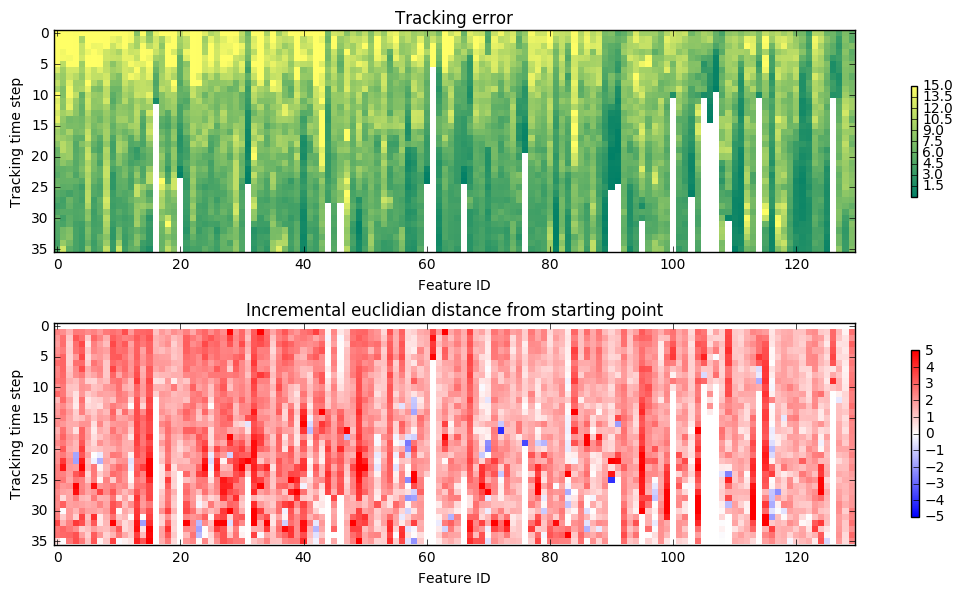

In [7]:
# Track good features
for i in range(trackstart, trackend):
    # track current corners in next image
    new, st, err = cv2.calcOpticalFlowPyrLK(prevImg=iframes[i], nextImg=iframes[i+1], prevPts=old, nextPts=None, **lk_params)
    success = st.ravel()==1
    ids = ids[success]
    sts[i, ids] = True
    x[i, ids] = old[success,0,0]
    y[i, ids] = old[success,0,1]
    errs[i, ids] = err.ravel()[success]
    # new corners will be old in the next loop
    old = new[success]

# Incremental euclidic distance from starting point
trackdist = np.diff( np.sqrt( (x-x[0].reshape((1,-1)))**2 + (y-y[0].reshape((1,-1)))**2 ), axis=0 )
trackdist = np.vstack( (np.zeros((1,trackdist.shape[1])), trackdist))

# Plot feature persistence
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(211)
cb = plt.imshow(errs, interpolation="none", cmap="summer", vmax = 15)
plt.xlabel("Feature ID")
plt.ylabel("Tracking time step")
plt.colorbar(cb, shrink=0.5)
plt.title("Tracking error")

# Plot consistence of movement
ax = fig.add_subplot(212)
cb = plt.imshow(trackdist, interpolation="none", cmap="bwr", vmin=-5, vmax=5)
plt.xlabel("Feature ID")
plt.ylabel("Tracking time step")
plt.colorbar(cb, shrink=0.75)
plt.title("Incremental euclidian distance from starting point")

plt.tight_layout()

In [8]:
# Find good tracks (but what is a "good" track...?)
#   Certainly a lot of subjective criteria to play with...
goodtrack = np.zeros(x.shape[1], dtype=np.bool)
for i in range(len(goodtrack)):
    # persistence of the track
    if len(np.where(sts[:,i])[0]) < 2:
        continue
    # consistency of movement
    if len(np.where(trackdist[:,i]<0)[0]) > 0:
        continue
    # tracking error
    if len(np.where(errs[:,i]>15)[0]) > 5:
        continue
    goodtrack[i] = True
print "Found %d good tracks and %d bad tracks." % (len(np.where(goodtrack)[0]), len(goodtrack)-len(np.where(goodtrack)[0])) 

Found 68 good tracks and 62 bad tracks.


C:\Anaconda3\envs\wradlib09\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\envs\wradlib09\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in greater


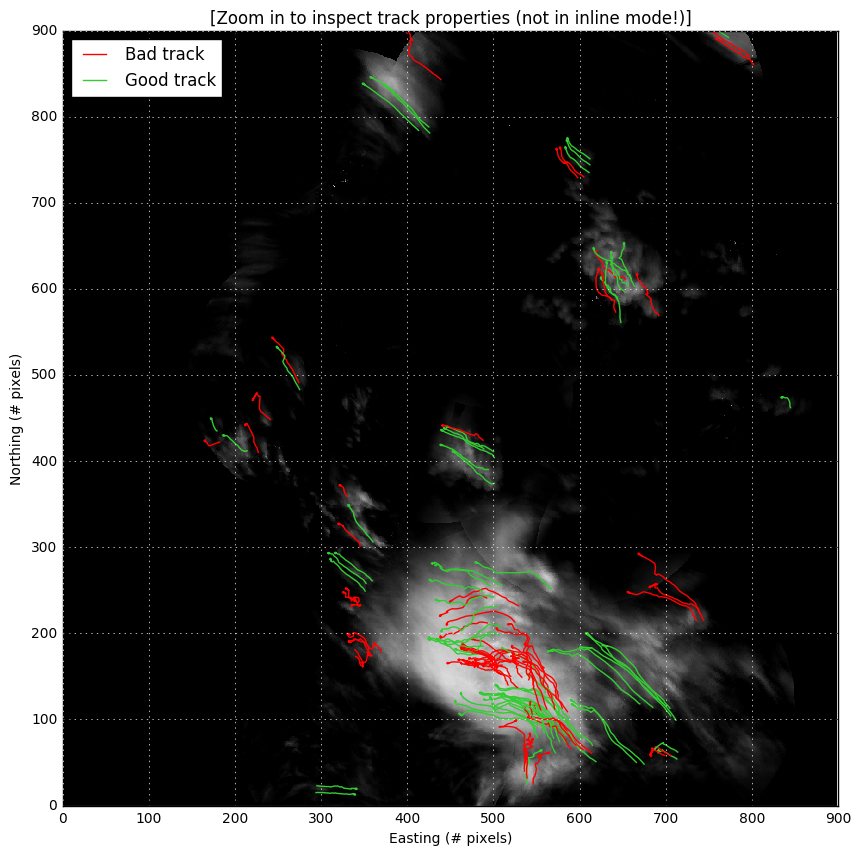

In [14]:
# Visualize tracks: green=good track, red=bad track
goodcolor = "limegreen"
badcolor = "red"
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, aspect="equal")
# average reflectivity over entire tracking period as background image
ax.imshow(np.mean(frames[trackstart:trackend], axis=0), origin="lower", cmap="gray", interpolation="none")
plt.xlabel("Easting (# pixels)")
plt.ylabel("Northing (# pixels)")
plt.title("[Zoom in to inspect track properties (not in inline mode!)]")
plt.grid(color="white")
plt.xlim(0,nx/downsizeby)
plt.ylim(0,nx/downsizeby)
bad_line = plt.Line2D([], [], color=badcolor, label='Bad track')
good_line = plt.Line2D([], [], color=goodcolor, label='Good track')
plt.legend(handles=[bad_line, good_line], loc="upper left")
for i, isgood in enumerate(goodtrack):
    ix = sts[:,i]
    color = badcolor
    if isgood:
        color = goodcolor
    ax.plot(x[ix,i], y[ix,i],marker="None", color=color, markersize=14, linestyle="-")
    ax.arrow(x[ix,i][-2], y[ix,i][-2],
             np.diff(x[ix,i][-2:])[0], np.diff(y[ix,i][-2:])[0], 
             head_width=2, head_length=2, fc=color, ec=color)

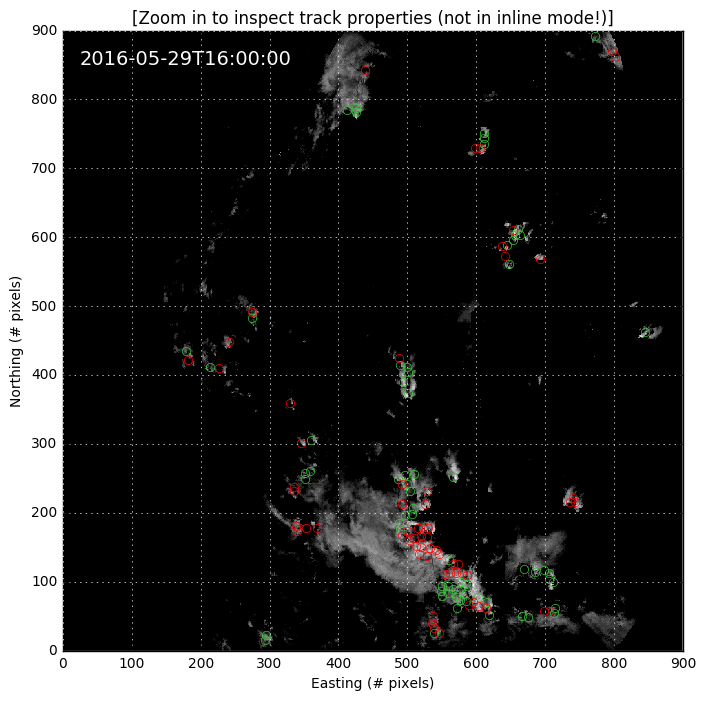

In [15]:
# Animate features

# Prepare canvas
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(111,aspect="equal")
im1 = ax1.imshow(iframes[trackstart], origin="lower", cmap="gray", interpolation="none")
plt.xlabel("Easting (# pixels)")
plt.ylabel("Northing (# pixels)")
plt.title("[Zoom in to inspect track properties (not in inline mode!)]")
plt.grid(color="white")
plt.xlim(0,nx/downsizeby)
plt.ylim(0,nx/downsizeby)
ax1.plot(x[0,goodtrack], y[0,goodtrack], linestyle="None", marker="o", mfc="None", mec="limegreen")
ax1.plot(x[0,~goodtrack], y[0,~goodtrack], linestyle="None", marker="o", mfc="None", mec="red")
ax1.grid(color="white")
tstamp1 = ax1.text(25, 850, dtimes[trackstart].isoformat(), color="white", fontsize=14)

def animate(j):
    im1.set_array(iframes[trackstart+j])
    for line in gca().get_lines():
        if not line.get_linestyle()=="None":
            line.remove()
    for i, isgood in enumerate(goodtrack):
        ix = np.where(sts[:j,i])[0]
        color = "red"
        if isgood:
            color = "limegreen"
        ax1.plot(x[ix,i], y[ix,i], marker="None", color=color, markersize=14, linestyle="-")
    tstamp1.set_text(dtimes[trackstart+j].isoformat())
    return im1

# ATTENTION: THIS IS SLOW - Rendering each frame of the animation might take more time than the interval between the frames
#    This can cause the temporal sequence to be confused in the matplotlib interactive mode.
#    The animation thus looks better if saved as movie, or you have to increase the interval argument
#    Animation not shown in notebook if you use %pylab inline
ani = animation.FuncAnimation(fig, animate, frames=np.arange(trackstart, trackend-1), interval=400, blit=False)
ani.save("features.avi", dpi=500, bitrate=2000)

### Update tracked corners for each time step of the considered tracking period

Until now, we only tracked those corners which we detected in the initial time step. We now want to add new tracks with each addtional time step, and follow these as well. 

In [16]:
init_crns = [cv2.goodFeaturesToTrack(iframes[i], mask = None, **feature_params) for i in range(trackstart, trackend)]
print "List of # corners in each time step:\n", [len(crn) for crn in init_crns ]

List of # corners in each time step:
[130, 165, 163, 176, 138, 143, 158, 134, 197, 159, 155, 116, 119, 128, 131, 127, 147, 161, 115, 73, 68, 50, 75, 106, 99, 106, 96, 102, 147, 164, 121, 102, 94, 121, 153, 102]


In [17]:
# this function wraps up everything which we already did above for a single set of corners
def tracker(old, frameset, lk_params):
    # Set containers to collect results (time steps in rows, corners in columns)
    #   Tracking status
    sts = np.zeros((trackend,len(old)), dtype=np.bool)
    #   corner x coords
    x = np.zeros((trackend,len(old))) * np.nan
    #   corner y coords
    y = np.zeros((trackend,len(old))) * np.nan
    #   tracking error
    errs = np.zeros((trackend,len(old))) * np.nan
    #   Assign persistent corner IDs
    ids = np.arange(len(old))
    # Track good features
    for i in range(len(frameset)-1):
        # track current corners in next image
        new, st, err = cv2.calcOpticalFlowPyrLK(prevImg=frameset[i], nextImg=frameset[i+1],
                                                prevPts=old, nextPts=None, **lk_params)
        success = st.ravel()==1
        ids = ids[success]
        sts[i, ids] = True
        x[i, ids] = new[success,0,0]
        y[i, ids] = new[success,0,1]
        errs[i, ids] = err.ravel()[success]
        # new corners will be old in the next loop
        old = new[success]

    # Incremental euclidic distance from starting point
    trackdist = np.diff( np.sqrt( (x-x[0].reshape((1,-1)))**2 + (y-y[0].reshape((1,-1)))**2 ), axis=0 )
    trackdist = np.vstack( (np.zeros((1,trackdist.shape[1])), trackdist))

    # Find good tracks (but what is a "good" track...?)
    goodtrack = np.zeros(x.shape[1], dtype=np.bool)
    for i in range(len(goodtrack)):
        # persistence of the track
        if len(np.where(sts[:,i])[0]) < 2:
            continue
        # consistency of movement
        if len(np.where(trackdist[:,i]<0)[0]) > 0:
            continue
        # tracking error
        if len(np.where(errs[:,i]>15)[0]) > 5:
            continue
        goodtrack[i] = True
    
    return sts, x, y, errs, goodtrack    

In [18]:
sts_ls, x_ls, y_ls, errs_ls, goodtrack_ls = [], [], [], [], []
for i, crns in enumerate(init_crns):
    sts, x, y, errs, goodtrack = tracker(crns, iframes[i:], lk_params)
    sts_ls.append(sts)
    x_ls.append(x)
    y_ls.append(y)
    errs_ls.append(errs)
    goodtrack_ls.append(goodtrack)

C:\Anaconda3\envs\wradlib09\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: invalid value encountered in less
C:\Anaconda3\envs\wradlib09\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in greater


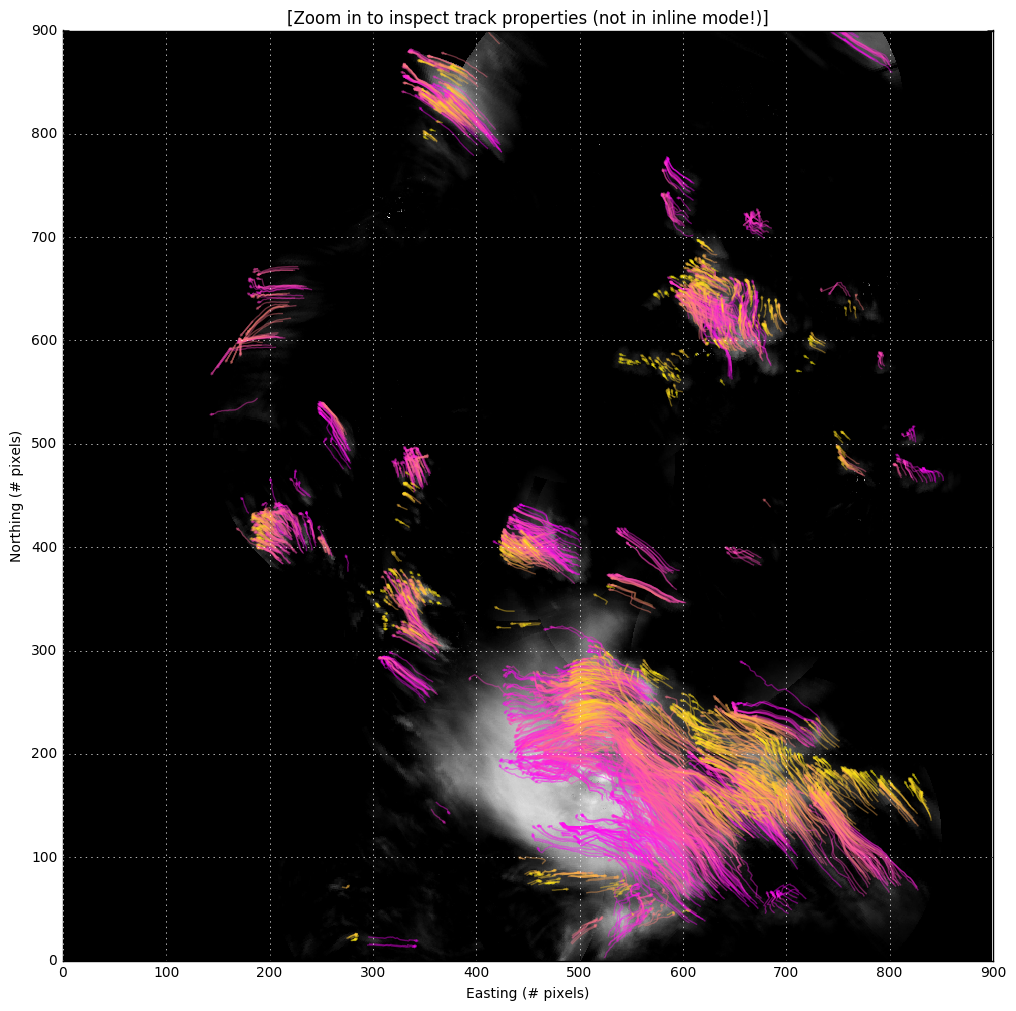

In [19]:
# Visualize tracks:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, aspect="equal")
# average reflectivity as background image
ax.imshow(np.mean(frames[trackstart:trackend], axis=0), origin="lower", cmap="gray", interpolation="none")
plt.xlabel("Easting (# pixels)")
plt.ylabel("Northing (# pixels)")
plt.title("[Zoom in to inspect track properties (not in inline mode!)]")
plt.grid(color="white")
plt.xlim(0,nx/downsizeby)
plt.ylim(0,nx/downsizeby)
colors = [ plt.cm.spring(i) for i in np.linspace(0,254, len(goodtrack_ls)).astype("i4") ]
for j, goodtrack in enumerate(goodtrack_ls[:-2]):
    sts, x, y = sts_ls[j], x_ls[j], y_ls[j]
    for i, isgood in enumerate(goodtrack):
        ix = sts[:,i]
        # HERE WE DO NOT PLOT THE BAD TRACKS
        color = "none"
        if isgood:
            color = colors[j]
        ax.plot(x[ix,i], y[ix,i],marker="None", color=color, linestyle="-", alpha=0.4)
        ax.arrow(x[ix,i][-2], y[ix,i][-2],
                 np.diff(x[ix,i][-2:])[0], np.diff(y[ix,i][-2:])[0], 
                 head_width=2, head_length=2, fc=color, ec=color, alpha=0.4)

In [ ]:
# ATTENTION: THIS ANIMATION TAKES A LONG WHILE (SEVERAL MINUTES) AND MIGHT STILL BE BUGGY

# Prepare canvas
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(111,aspect="equal")
im1 = ax1.imshow(iframes[trackstart], origin="lower", cmap="gray", interpolation="none")
plt.xlabel("Easting (# pixels)")
plt.ylabel("Northing (# pixels)")
plt.title("[Zoom in to inspect track properties (not in inline mode!)]")
plt.grid(color="white")
plt.xlim(0,nx/downsizeby)
plt.ylim(0,nx/downsizeby)
#ax1.plot(x[0,goodtrack], y[0,goodtrack], linestyle="None", marker="o", mfc="None", mec=colors[0])
ax1.grid(color="white")
tstamp1 = ax1.text(25, 850, dtimes[trackstart].isoformat(), color="white", fontsize=14)

def animate(j):
    im1.set_array(iframes[trackstart+j])
    for line in gca().get_lines():
        line.remove()
        #if not line.get_linestyle()=="None":
        #    line.remove()
    for k, goodtrack in enumerate(goodtrack_ls[:j]):
        sts, x, y = sts_ls[k], x_ls[k], y_ls[k]
        for i, isgood in enumerate(goodtrack):
            ix = np.where(sts[:j,i])[0]
            # HERE WE DO NOT PLOT THE BAD TRACKS
            color = "none"
            if isgood:
                color = colors[k]
            #ax1.plot(x[0,goodtrack], y[0,goodtrack], linestyle="None", marker="o", mfc="None", mec=color, alpha=0.4)
            ax1.plot(x[ix,i], y[ix,i],marker="None", color=color, linestyle="-", alpha=0.4)
# ATTENTION: THIS IS SLOW - Rendering each frame of the animation might take more time than the interval between the frames
#    This can cause the temporal sequence to be confused.
#    The animation thus looks better if saved as movie, or you have to increase the interval argument
ani = animation.FuncAnimation(fig, animate, frames=np.arange(trackstart, trackend-1), interval=200, blit=False)
ani.save("features2.avi", dpi=500, bitrate=2000)

### Experiment with SIFT/SURF feature detection and description

See [SIFT and SURF](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html) for feature detection. Right now, this does not seem to add value as compared to the Optical Flow approach above. Features seem to be much less persistent.

In [20]:
# SURF
surf = cv2.xfeatures2d.SURF_create(3000)

kplist = []
deslist= []

for i in range(trackstart, trackend):
    kp, des = surf.detectAndCompute(iframes[i],None)
    kplist.append(kp)
    deslist.append(des)
    print "Found %d keypoints in step %d." % (len(kp), i)

Found 149 keypoints in step 0.
Found 147 keypoints in step 1.
Found 152 keypoints in step 2.
Found 141 keypoints in step 3.
Found 162 keypoints in step 4.
Found 159 keypoints in step 5.
Found 153 keypoints in step 6.
Found 140 keypoints in step 7.
Found 147 keypoints in step 8.
Found 151 keypoints in step 9.
Found 142 keypoints in step 10.
Found 154 keypoints in step 11.
Found 161 keypoints in step 12.
Found 146 keypoints in step 13.
Found 148 keypoints in step 14.
Found 152 keypoints in step 15.
Found 130 keypoints in step 16.
Found 128 keypoints in step 17.
Found 130 keypoints in step 18.
Found 122 keypoints in step 19.
Found 120 keypoints in step 20.
Found 115 keypoints in step 21.
Found 125 keypoints in step 22.
Found 107 keypoints in step 23.
Found 112 keypoints in step 24.
Found 135 keypoints in step 25.
Found 134 keypoints in step 26.
Found 141 keypoints in step 27.
Found 128 keypoints in step 28.
Found 112 keypoints in step 29.
Found 102 keypoints in step 30.
Found 106 keypoint

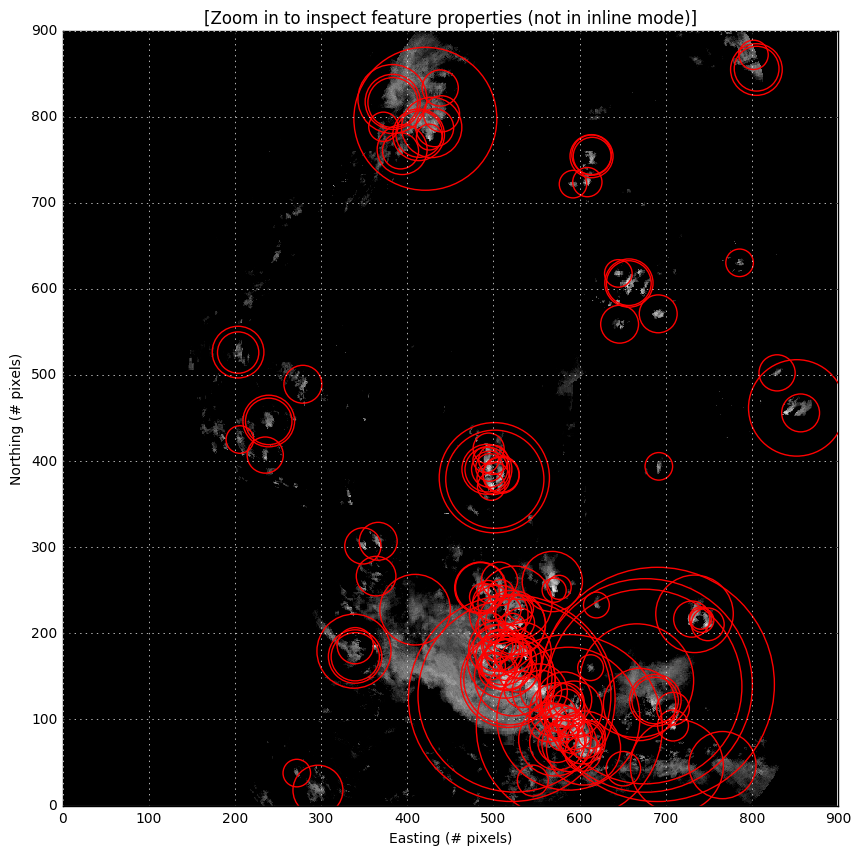

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, aspect="equal")
# average reflectivity as background image
ax.imshow(frames[0], origin="lower", cmap="gray", interpolation="none")
plt.xlabel("Easting (# pixels)")
plt.ylabel("Northing (# pixels)")
plt.title("[Zoom in to inspect feature properties (not in inline mode)]")
tstamp1 = ax1.text(25, 850, dtimes[0].isoformat(), color="white", fontsize=14)
plt.grid(color="white")
plt.xlim(0,nx/downsizeby)
plt.ylim(0,nx/downsizeby)
patches = []
for kp_ in kplist[0]:
    if kp_.size > 5:
        circle = mpatches.Circle(kp_.pt, kp_.size, fill=False, edgecolor="red")
    #ax.add_patch(circle)
    patches.append(circle)
collection = PatchCollection(patches, facecolor="none", edgecolor="red")
ax.add_collection(collection)

In [24]:
# Make list of patch collections for all timesteps
def collect(kp):
    patches = []
    for kp_ in kp:
        if (kp_.size > 10) and (kp_.size < 50):
            circle = mpatches.Circle(kp_.pt, kp_.size, fill=False, edgecolor="red")
            patches.append(circle)
    return(PatchCollection(patches, facecolor="none", edgecolor="red"))

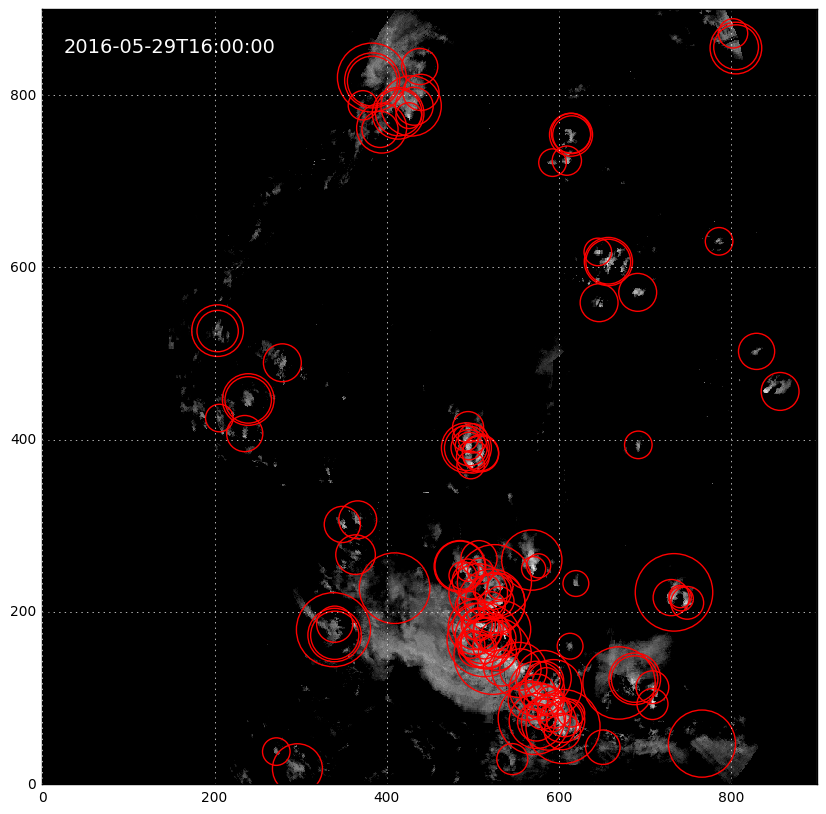

In [27]:
# Animate features
_plot_style = dict(markersize=12, markeredgewidth=2,
                       markerfacecolor='none', markeredgecolor='r',
                       marker='o', linestyle='none')
_pcm_style = dict(cmap=plt.cm.spectral, vmin=0., vmax=30.)

# Prepare canvas
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(111,aspect="equal")
im1 = ax1.imshow(iframes[0], origin="lower", cmap="gray", interpolation="none")
ax1.add_collection(collect(kplist[0]))
ax1.grid(color="white")
tstamp1 = ax1.text(25, 850, dtimes[0].isoformat(), color="white", fontsize=14)


def animate(i):
    im1.set_array(iframes[trackstart+i])
    ax1.collections = []
    ax1.add_collection(collect(kplist[trackstart+i]))
    tstamp1.set_text(dtimes[trackstart+i].isoformat())
    return im1

ani = animation.FuncAnimation(fig, animate, frames=np.arange(trackstart, trackend-1), interval=200, blit=False)
ani.save("features_surf.avi", dpi=400, bitrate=2000)

### Match features (brute force)

According [Bowler et al. (2004)](http://www.sciencedirect.com/science/article/pii/S0022169403004591), maximum advection velocity of rainfall objects is about 130 km/h which is roughly 10 km (pixels) in 5 minutes. 

In [28]:
maxveloc = 10.
# Detect initial feature set 
detector = cv2.xfeatures2d.SURF_create(3000)
kp1, des1 = detector.detectAndCompute(iframes[trackstart],None)

# create BFMatcher object
bf = cv2.BFMatcher()

kp1_ls = []
kp2_ls = []

for i in range(trackstart+1, trackend):
    kp2, des2 = detector.detectAndCompute(iframes[i],None)
    matches = bf.knnMatch(des1, des2, k=1)
    # Select matches to keep
    kp1_, des1_, kp2_, des2_  = [], [], [], []
    for match in matches:
        match=match[0]
        xy = np.vstack( (kp1[match.queryIdx].pt, kp2[match.trainIdx].pt) )
        eucdist = np.sqrt( (xy[0,0] - xy[1,0])**2 + (xy[0,1] - xy[1,1])**2 )
        if eucdist < maxveloc:
            kp1_.append( kp1[match.queryIdx] )
            des1_.append( np.array( des1[match.queryIdx] ) )
            kp2_.append( kp2[match.trainIdx] )
            des2_.append( np.array( des2[match.trainIdx] ) )
    kp1_ls.append(kp1_)
    kp2_ls.append(kp2_)
    # Update initial feature set
    kp1, des1 = kp2_, np.array( des2_ )